In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.custom_net import *
from models.sfcn_grade import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.ranking_loss import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        # normalized images
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class SEBlock(nn.Module):
    
    def __init__(self, in_channels, r=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels//r),
            nn.ReLU(),
            nn.Linear(in_channels//r, in_channels),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1, 1)
        return x

In [8]:
img_dir = 'img_npy/'
label_dir = 'labels/data_grade_foruse.csv'
label_name = 'GRADE'

In [9]:
weight_decay = 1e-6 #0.01
lr = 0.0005 # 0.0001
epochs = 80
batch_size = 16
optimizer = optim.Adam
dropout_rate = 0.5
test_size = 0.2
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
#                                                lr_lambda=lambda epoch: 0.3 ** epoch)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [11]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = torch.FloatTensor(self.X[idx])
        label = torch.LongTensor(self.y)[idx]
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [12]:
def train(model, train_loader, lr, weight_decay, optim_class=optim.AdamW, scheduler=None):
    criterion = nn.CrossEntropyLoss()
        
    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    total_loss = 0
    correct = 0
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        
        # move data to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # clear previous gradient computation
        optimizer.zero_grad()

        # forward prop
        output = model(inputs)
#         print('y: {} / y hat: {}'.format(labels, output))
            
        # calculate loss with cost function
        loss = criterion(output, labels)
        
        # back prop
        loss.backward()
        
        # update model weights
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        # accumulate loss
        total_loss += loss.data.item()
        
        # accumulate correct count
        _, preds = torch.max(output, 1)
        correct += torch.sum(preds == labels.data)
                
        gc.collect()
        torch.cuda.empty_cache()
        
    return total_loss, correct

In [13]:
def valid(model, valid_loader):
    criterion = nn.CrossEntropyLoss()
    
    total_loss = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            
            # move data to the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward prop
            output = model(inputs)

            # calculate loss with cost function
            loss = criterion(output, labels)
            
            # accumulate loss
            total_loss += loss.data.item()
            
            # accumulate correct count
            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels.data)
                    
    return total_loss, correct

---

In [14]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=False, norm=True)  # std=False, norm=True

# initialize seed
set_seed()

# prepare train set and validation set
dataset = NeckDataset(X, y)
train_set, valid_set = train_test_split(dataset, test_size=test_size)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=16)

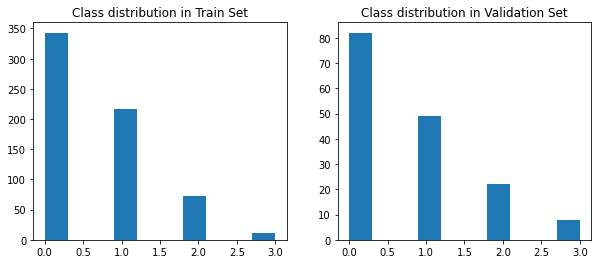

In [15]:
# plot class distribution histogram
plt.figure(figsize=(10,4))

y_train, y_test = [], []
for _, data in train_set:
    y_train.append(data)
for _, data in valid_set:
    y_test.append(data)

plt.subplot(1,2,1)
plt.title('Class distribution in Train Set')
plt.hist(y_train)

plt.subplot(1,2,2)
plt.title('Class distribution in Validation Set')
plt.hist(y_test)

plt.show()
plt.close()

In [ ]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=False, norm=True)  # std=False, norm=True

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [ ]:
# plot class distribution histogram
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Class distribution in Train Set')
y_train.hist(grid=False)

plt.subplot(1,2,2)
plt.title('Class distribution in Validation Set')
y_test.hist(grid=False)

plt.show()
plt.close()

In [ ]:
# # train / validation
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# len(y_train), len(y_val), len(y_test)

In [ ]:
# # validation set
# valid_set = NeckDataset(X_val, y_val)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=16)

# # test set
# test_set = NeckDataset(X_test, y_test)
# test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

In [ ]:
# train set
train_set = NeckDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

In [ ]:
# validation set
valid_set = NeckDataset(X_test, y_test)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=16)

In [ ]:
from torch.autograd import Variable

for images, labels in valid_loader:
    i, l = Variable(images), Variable(labels)
    print(i.size())
    i = i.cpu().numpy()
    l = l.cpu().numpy()
    if l[0]==0:
        print('Label = {} : absent image'.format(l[0]))
    elif l[0]==1:
        print('Label = {} : punctate foci image'.format(l[0]))
    elif l[0]==2:
        print('Label = {} : beginning confluence image'.format(l[0]))
    else:
        print('Label = {} : large confluent areas image'.format(l[0]))
    plt.imshow(np.max(i[0].squeeze(), axis=1))
    plt.show()

In [ ]:
model.to(device)
for inputs, labels in tqdm(train_loader):              

    # move data to the GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward prop
    output = model(inputs)
    print(output.shape)
    break

In [16]:
set_seed()

#### model: custom simple net ####
model = CustomNet(depth=1, classes=4)
##################################

# #### model: simple net, last layer no activation function ####
# model = SFCN(output_dim=4)
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# ###########################

# #### model: simple SE net ####
# model = SFCN()
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# model.seblock = SEBlock(64)
# model.forward = types.MethodType(forward, model)
# ##############################

# #### model: resnet26 ####
# model = resnet26(in_channels=1, num_classes=4)
# #########################

# #### model: inception-resnet-v2 ####
# model = inception_resnet_v2(in_channels=1, num_classes=1)
# ####################################

# #### model: densenet ####
# model = densenet(121, in_channels=1, num_classes=1)
# #########################

model

CustomNet(
  (feature_extractor): Sequential(
    (conv1): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (classifier): Sequential(
    (0): AvgPool3d(kernel_size=[15, 6, 9], stride=[15, 6, 9], padding=0)
    (1): Dropout(p=

In [18]:
test_size, batch_size

(0.2, 16)

In [17]:
model.to(device)
wandb.init(project='classification-test-4class',
           config={"model": "shallowNet2", "dropout": dropout_rate, 
                   "lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "test_size": test_size})
wandb.watch(model)

best_rec = 0   # best_rec: best accuracy

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))
#     augment = get_augmentation_transform()
#     train_set = NeckDataset(X_train, y_train, transform=augment)
#     train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # log image to check if augmentation is same for every experiment
    tensor_img = train_set[0][0].squeeze().cpu().detach().numpy()
    img = wandb.Image(np.max(tensor_img, axis=1), caption="Coronal MIP")

    loss_t, corr_t = train(model, train_loader, lr, weight_decay, optimizer)
    loss_v, corr_v = valid(model, valid_loader)

    train_loss = loss_t / len(train_loader)
    train_acc = 100 * corr_t / len(train_set)
    
    valid_loss = loss_v / len(valid_loader)
    valid_acc = 100 * corr_v / len(valid_set)

    if best_rec < valid_acc:
        best_rec = valid_acc
#         torch.save(model.state_dict(), 'pretrained/221129_4classtest0.2x16noaug_best')

    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "valid_loss": valid_loss, "valid_acc": valid_acc,
               "sample_img": img})
wandb.finish()
# torch.save(model.state_dict(), f'pretrained/221129_4classtest0.2x16noaug_epoch{epochs}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


# Epoch 2 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.56it/s]


# Epoch 3 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.50it/s]


# Epoch 4 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 5 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 6 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.36it/s]


# Epoch 7 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.37it/s]


# Epoch 8 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


# Epoch 9 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.32it/s]


# Epoch 10 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.42it/s]


# Epoch 11 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


# Epoch 12 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.33it/s]


# Epoch 13 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.39it/s]


# Epoch 14 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


# Epoch 15 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


# Epoch 16 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


# Epoch 17 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.41it/s]


# Epoch 18 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


# Epoch 19 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.32it/s]


# Epoch 20 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.46it/s]


# Epoch 21 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.50it/s]


# Epoch 22 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.53it/s]


# Epoch 23 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s]


# Epoch 24 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.45it/s]


# Epoch 25 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.47it/s]


# Epoch 26 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


# Epoch 27 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.52it/s]


# Epoch 28 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 29 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.38it/s]


# Epoch 30 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.45it/s]


# Epoch 31 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.48it/s]


# Epoch 32 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.49it/s]


# Epoch 33 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.56it/s]


# Epoch 34 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


# Epoch 35 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.46it/s]


# Epoch 36 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


# Epoch 37 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s]


# Epoch 38 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.28it/s]


# Epoch 39 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


# Epoch 40 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.41it/s]


# Epoch 41 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


# Epoch 42 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 43 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.55it/s]


# Epoch 44 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.56it/s]


# Epoch 45 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.55it/s]


# Epoch 46 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 47 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.58it/s]


# Epoch 48 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.36it/s]


# Epoch 49 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.53it/s]


# Epoch 50 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.36it/s]


# Epoch 51 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.45it/s]


# Epoch 52 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


# Epoch 53 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.33it/s]


# Epoch 54 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


# Epoch 55 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


# Epoch 56 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.31it/s]


# Epoch 57 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s]


# Epoch 58 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.28it/s]


# Epoch 59 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.43it/s]


# Epoch 60 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


# Epoch 61 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


# Epoch 62 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.56it/s]


# Epoch 63 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.35it/s]


# Epoch 64 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.40it/s]


# Epoch 65 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.32it/s]


# Epoch 66 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


# Epoch 67 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s]


# Epoch 68 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.36it/s]


# Epoch 69 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


# Epoch 70 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.37it/s]


# Epoch 71 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.33it/s]


# Epoch 72 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.43it/s]


# Epoch 73 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


# Epoch 74 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.42it/s]


# Epoch 75 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.37it/s]


# Epoch 76 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


# Epoch 77 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.52it/s]


# Epoch 78 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.34it/s]


# Epoch 79 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.52it/s]


# Epoch 80 / 80


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s]


train_acc,▁▂▃▃▃▄▄▅▅▄▅▅▄▄▆▆▅▅▆▅▇▇▅▆▅▇▇▆▇▆▇▆▇▇▆▆▇▇▇█
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▄▃▃▃▃▃▂▃▂▂▃▂▂▂▃▂▃▂▂▂▁▂▁
valid_acc,▁▅▅▅▆▆▃▄▆▄▄▂▂▅▃▃▆▃▇▂▃▂▄▆▄▃▅▄█▇▃▂▁▃▅▂▄▄▆▂
valid_loss,█▅▃▃▃▂▂▃▂▂▂▂▁▁▂▁▁▂▂▃▂▂▂▂▅▂▆▆▃▃▂▄▃▃▅▅▅▅▆▂
train_acc,66.40746
train_loss,0.76498
valid_acc,52.17392
valid_loss,0.94467


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predict(model, data_loader):
    model.eval()
    
    y_pred_list, y_list = np.array([]), np.array([])
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            
            # move data to the GPU
            inputs = inputs.to(device)
            
            # forward prop
            output = model(inputs)
                        
            # store predicted values
            _, preds = torch.max(output, dim=1)
            pred = preds.detach().cpu().numpy()
            y_pred_list = np.append(y_pred_list, pred.reshape(pred.size), axis=0)
            
            # store truth values
            truth = labels.detach().numpy()
            y_list = np.append(y_list, truth.reshape(truth.size), axis=0)
            
    return y_list, y_pred_list

In [19]:
y_list, y_preds = predict(model, valid_loader)

100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


[Text(33.0, 0.5, 'ground truth'), Text(0.5, 15.0, 'predicted')]

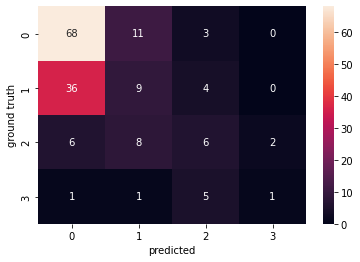

In [20]:
# confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_list, y_preds))
s = sns.heatmap(confusion_matrix_df, annot=True)
s.set(ylabel='ground truth', xlabel='predicted')

In [21]:
# classification report
print(classification_report(y_list, y_preds))

              precision    recall  f1-score   support

         0.0       0.61      0.83      0.70        82
         1.0       0.31      0.18      0.23        49
         2.0       0.33      0.27      0.30        22
         3.0       0.33      0.12      0.18         8

    accuracy                           0.52       161
   macro avg       0.40      0.35      0.35       161
weighted avg       0.47      0.52      0.48       161



In [22]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_target, y_predicted, class_label, guideline=False):
    fpr, tpr, threshold = metrics.roc_curve(y_target, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, label='%d: AUC = %0.2f' % (class_label, roc_auc))
    plt.legend(loc='lower right')
    if guideline:
        plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def roc_auc_score_multiclass(actual_class, pred_class, average="macro", guideline=False):
    
    # create a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    
    for per_class in unique_class:
        
        # create a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]
        
        # mark the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        
        # calculate the roc_auc score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        
        plot_roc_curve(new_actual_class, new_pred_class, per_class, guideline)
        
    plt.show()
        
    return roc_auc_dict

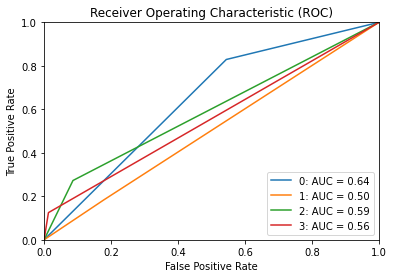

{0.0: 0.6424822476072861,
 1.0: 0.5025510204081632,
 2.0: 0.593198168737737,
 3.0: 0.5559640522875817}

In [23]:
roc_auc_dict = roc_auc_score_multiclass(y_list, y_preds)
roc_auc_dict